<a href="https://colab.research.google.com/github/byi8220/unsloth-puzzles/blob/main/Problem5/MemEffLinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsloth Problem 5 - Memory Efficient Backprop

#### Ran on a colab A100 GPU instance with 40 GB VRAM, 80 GB RAM

First few cells are the problem statement and setup code. The solution starts [here](#problem-5-impl)


A100s are expensive, but is needed in order to get the default, (non-memory efficient) test case where `bsz = 4, qlen = 4096, hd = 4096, vocab = 128K` to run.

## Problem Statement
<a name="MATH"></a>
## E) Memory Efficient Backprop [Difficulty: Medium to Hard] [Max points: 10]

In LLMs, the last layer is a projection matrix to calculate the probabilities of the next token, ie $\sigma(XW)$. However, if the vocabulary size is very large, say 128K, then the materialization of the logits causes VRAM spikes.

For example, if the `bsz = 4, qlen = 4096, hd = 4096, vocab = 128K`, then the memory usage for the logits in bfloat16 would be 4GB. In the worst case, we might even need to upcast logits to float32, so 8GB is needed.

In Unsloth, we utilize [Apple's Cut Cross Entropy Loss](https://machinelearning.apple.com/research/cut-your-losses) to reduce VRAM usage, by allowing a Triton kernel to create the logits on the fly to calculate the cross entropy loss. But this does not generalize well to other functions.

Our goal is to generalize this ultimately, but directly creating logits on the fly will be hard. Instead, let's take a slightly less complex approach. Let's first review some stuff. We first notice that during the normal case after forming the intermediate logits for 2 batches, we then do a gather function to aggregate the intermediate results into a single column:
$$
\begin{align}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \times W &= \begin{bmatrix} x_1 W \\ x_2 W \end{bmatrix} \\
f \bigg( \begin{bmatrix} x_1 W \\ x_2 W \end{bmatrix} \bigg) &= \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}
\end{align}
$$

So, if we can somehow skip the materialization of the intermediate logits, and just output the output of `f`, we can save a lot of VRAM!

Notice during backpropagation we can use the chain rule:
$$
\begin{align}
\frac{dL}{dX} &= \frac{dL}{dy} \frac{dy}{dX} ; \frac{dL}{dW} = \frac{dL}{dy} \frac{dy}{dW} \\
\frac{dL}{dy} &= \text{Downstream from backprop} \\
\frac{dy}{dX} &= W^T \\
\frac{dy}{dW} &= X^T \\
\frac{dL}{dX} &= \frac{dL}{dy} W^T \\
\frac{dL}{dW} &= X^T \frac{dL}{dy} \\
\end{align}
$$

If we simply compute the intermediate tensors on the fly via batches, say we do batch 1, then batch 2, we can reduce VRAM usage from 4GB to 2GB!

$$
\begin{align}
\frac{dL}{dX} &= \begin{bmatrix} \frac{dL_1}{dy_1} W^T \\ \frac{dL_2}{dy_2} W^T \end{bmatrix} \\
\frac{dL}{dW} &= \bigg( X_1^T \frac{dL_1}{dy_1} + X_2^T  \frac{dL_2}{dy_2} \bigg)
\end{align}
$$

1. Your goal is to write a `torch.autograd.Function` with a `forward` and `backward` pass showcasing this memory efficient implementation.

2. You must NOT hard code the derivatives - move the transformation function from the logits / intermeditate tensors to a smaller tensor as a separate function which can allow `autograd` to pass through it.

3. As a hint, look at `torch.checkpoint` at https://github.com/pytorch/pytorch/blob/main/torch/utils/checkpoint.py. Also, don't forget about the upstream gradients! We need to multiply them to the current gradients!

4. Make the Cross Entropy Loss work. You must show other functions working as well.

---
## Setup
---

In [1]:
# Code to install Unsloth, Triton, Torch etc
%%capture
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
!pip install --no-deps cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

In [2]:
# Helpful functions used through the entire notebook
import torch
import torch.nn as nn
from transformers import set_seed
import time
import inspect
import os
major_version, minor_version = torch.cuda.get_device_capability()
HAS_BFLOAT16 = (major_version >= 8)
from inspect import currentframe as _C, getframeinfo
_F = lambda c: getframeinfo(c).lineno # Gets line number
WARN = lambda x: print(f"\033[31m{x}\033[0m") # Red colored warnings

# https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
def NAME(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    names = [var_name for var_name, var_val in callers_local_vars if var_val is var]
    return names[0] if len(names) != 0 else ""

def assert_same(x, y, line, dtype):
    assert(x.dtype == dtype)
    try: torch.testing.assert_close(x, y, check_stride = True)
    except Exception as error:
        raise RuntimeError(
            f"Failed allclose at line [{line}]: {NAME(x)}, {NAME(y)}\n{str(error)}"
        )

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

---
<a name="problem-5-impl"><a/>
## `MemoryEfficientLinear` Implementation


### Constraints
The exact requirements for `MemoryEfficientLinear` were unclear to me, so I made the following assumptions:

1. `forward_function` is a loss function that aggregates output projections and predictions into a single, scalar loss value.
2. `forward_function` is reduced by mean.

`MemoryEfficientLinear` takes in an argument `mel_num_chunks=B`, where `B` controls how we split processing across batches. For example, if `bsz=4` and `B=2`, then we compute gradients for batches `{0,1}` and `{2,3}` in separate passes.

In [3]:
import torch.nn.functional as F
import math

def transformation_function(batch, linear, labels):
    x = linear(batch).float() # Up projection to large space
    from torch.nn import CrossEntropyLoss
    down_projection_function = CrossEntropyLoss(reduction = "mean")
    # Down projection to small space
    loss = down_projection_function(x.view(-1, x.shape[-1]), labels.view(-1))
    return loss

def cross_entropy_f(x, labels):
    """The nonlinear part of `transformation_function`"""
    from torch.nn import CrossEntropyLoss
    down_projection_function = CrossEntropyLoss(reduction = "mean")
    # Down projection to small space
    loss = down_projection_function(x.reshape(-1, x.shape[-1]), labels.reshape(-1))
    return loss

class MemoryEfficientLinear(torch.autograd.Function):
    # IMO, the spec is a bit vague, and I interpreted the arguments to
    # as MemoryEfficientLinear.forward(X, W, labels, fn) = fn(XW, labels)
    @staticmethod
    # (bsz, qlen, hd) @ (hd, vocab) -> (bsz, qlen, vocab)
    def forward(ctx, X, W, labels, forward_function, mel_num_chunks=1, ignore_index=-100):
        # NOTE: I wasn't sure what `allows_dynamic_chunk_sizes` means here.
        # I interpreted it to mean "let the user specify the number of chunks,
        # and the chunks will be sized accordingly."
        ctx.mel_num_chunks = mel_num_chunks # How to chunk `XW` over batches

        # Perform `forward_function` in chunks, and reduce them into `output`
        output = 0.0

        # Require uniform chunk size, for cleaner computations involving
        # `ForCausalLMLoss` and `num_items_in_batch`.
        assert X.shape[0] % ctx.mel_num_chunks == 0
        assert ctx.mel_num_chunks <= X.shape[0]
        b_per_chunk = X.shape[0] // ctx.mel_num_chunks

        N = 0
        for b in range(ctx.mel_num_chunks):
            b0, b1 = b *  b_per_chunk, (b+1) * b_per_chunk
            # Reduce (bsz, qlen, vocab) to (b_per_chunk, q_per_chunk, vocab)
            with torch.no_grad():
                X_slice = X[b0:b1]
                l_slice = labels[b0:b1]
                XW_slice = (F.linear(X_slice, W.T)).float()
            output += torch.numel(l_slice) * forward_function(XW_slice, l_slice)
            N += torch.numel(l_slice)
        del XW_slice
        ctx.save_for_backward(X, W, labels)
        ctx.forward_function = forward_function
        ctx.N = N
        ctx.ignore_index = ignore_index
        return output / N

    # L(X,W,T,f) = f(XW, T)
    # dL/dX = dL/df * df/d(XW) * d(XW)/dX
    # dL/dW = dL/df * df/d(XW) * d(XW)/dW
    # We want to avoid materializing df/d(XW) to save on memory,
    # as XW is the large tensor we are trying to avoid materializing
    @staticmethod
    def backward(ctx, dY):

        # As written we need to retain at least all of X, W, labels
        # (This could possibly be optimized more)
        X, W, labels = ctx.saved_tensors

        # The absolute minimum memory usage this function can possibly incur is
        # that required for the returned gradients.
        dX = torch.zeros_like(X)
        dW = torch.zeros_like(W)
        assert X.shape[0] % ctx.mel_num_chunks == 0
        assert ctx.mel_num_chunks <= X.shape[0]
        b_per_chunk = X.shape[0] // ctx.mel_num_chunks

        for b in range(ctx.mel_num_chunks):
            b0, b1 = b * b_per_chunk, (b+1) * b_per_chunk
            X_slice = X[b0:b1].detach().requires_grad_()
            W_slice = W.detach().requires_grad_()
            l_slice = labels[b0:b1].detach()
            with torch.enable_grad():
                XW_slice = (F.linear(X_slice, W_slice.T)).float()
                out = ctx.forward_function(XW_slice, l_slice) * torch.numel(l_slice)
            # From my testing this appears to use more memory than hardcoded matmul (sometimes)
            dX_slice, dW_slice = torch.autograd.grad(out, (X_slice, W_slice), dY / ctx.N, retain_graph=False, create_graph=False)
            dX[b0:b1] = dX_slice.to(dX.dtype)
            dW += dW_slice.to(dW.dtype)

        return dX, dW, None, None, None, None


---
## `MemoryEfficientLinear` Tests


In [4]:
import torch
from functools import partial
import gc

# Set seed + reproducability
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" # Needed for CE Loss
# torch.manual_seed(69)
# torch.use_deterministic_algorithms(True)
# torch.utils.deterministic.fill_uninitialized_memory = True

# Make sure we're actually using cuda
device = 'cuda'

# Default config parameters
# `bsz=4` needs an A100 instance to run the base case
# `bsz=2` can be run on an L4 instance.
bsz = 4
qlen = 4096
hd = 4096
vocab = 128 * 1024 # 128k
dtype = torch.bfloat16
# The projection we are trying to optimize is of the form:
# (bsz, qlen, hd) @ (hd, vocab) -> (bsz, qlen, vocab)

### Test 1: Sanity Checks

In [5]:
# Create input

# With default config, this is 2 * 4096 * 4096 * 2 bytes = 64MB
batch = torch.randn((bsz, qlen, hd), dtype=dtype, requires_grad=True)
batch.retain_grad()

# With default config, this is 2 * 4096 * 4 bytes = 32KB
labels = torch.randint(0, vocab, (bsz, qlen), dtype=torch.long).to(device)

# With default config, this is 4096 * 128k * 2 bytes = 1GB
initial_W = torch.randn(hd, vocab, dtype=dtype)

##### Test: Run a backwards pass and check outputs


In [6]:
#### Run basic layer

# Initialize a linear layer
base_linear_ = torch.nn.Linear(hd, vocab, bias=False, dtype=dtype).to(device)
base_linear_.weight = torch.nn.Parameter(
    initial_W.T.clone().detach().to(device))
base_linear_.weight.grad = None

# Prepare input data
batch_in = batch.clone().detach().to(device).requires_grad_()
batch_in.retain_grad()
batch_in.grad = None

# Clear memory and stats to profile forward
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# (bsz, qlen, hd) @ (hd, vocab) -> (bsz, qlen, vocab) logits.
loss_expected = transformation_function(batch_in, base_linear_, labels.detach())
torch.cuda.synchronize()
base_linear_forward_mem = torch.cuda.max_memory_allocated()

# Without checkpointing, `backward()` doubles our memory usage since we need
# to persist intermediate state.

# Clear memory and stats to profile backward()
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Do the backward
loss_expected.backward()
torch.cuda.synchronize()
# Measure peak memory usage
# With the default config (and no checkpointing) we expect this to account for:
# 1. The parameters of base_linear - 4096 * 128k * sizeof(bfloat16) = 1GB
# 2. The upcasted, materialized logits - 2 * 4096 * 128k * sizeof(float) = 4GB
# 3. The memory needed for backprop - At least 4 GB
# 4. The gradients of `base_linear` - 4096 * 128k * sizeof(bfloat16) = 1GB
# 5. `batch` and `labels`, which are negligibly small (Under 200 MB)
# 6. The computed losses, which are just scalars
base_linear_backward_mem = torch.cuda.max_memory_allocated()

# Move to CPU to not interfere VRAM measurement
base_linear_batch_grad_values = batch_in.grad.clone().detach().to('cpu')
base_linear_grad_values = base_linear_.weight.grad.clone().detach().transpose(0,1).to('cpu')

# Free memory
loss_expected = loss_expected.detach().to('cpu') # Stop holding our old computation graph
del base_linear_, batch_in
gc.collect()
torch.cuda.empty_cache()

In [7]:
#### Run memory efficient layer

# Initialize a linear parameter.
mem_eff_linear_ = torch.nn.Parameter(initial_W.clone().detach().to(device))
memEffLinear = MemoryEfficientLinear.apply
mem_eff_linear_.grad = None

# Prepare input data
batch_in = batch.clone().detach().to(device).requires_grad_()
batch_in.retain_grad()
batch_in.grad = None

# Clear memory and stats to profile forward
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

num_chunks = 4
loss_actual = memEffLinear(batch_in,
                           mem_eff_linear_,
                           labels.detach(),
                           cross_entropy_f,
                           num_chunks)
torch.cuda.synchronize()
mem_eff_linear_forward_mem = torch.cuda.max_memory_allocated()

# Clear memory and stats to profile backward()
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Do the backward
loss_actual.backward()
torch.cuda.synchronize()
# Measure peak memory usage
mem_eff_linear_backward_mem = torch.cuda.max_memory_allocated()

# Move to CPU to not interfere VRAM measurement
mem_eff_batch_grad_values = batch_in.grad.clone().detach().to('cpu')
mem_eff_linear_grad_values = mem_eff_linear_.grad.clone().detach().to('cpu')

# Free memory
loss_actual = loss_actual.detach().to('cpu') # Stop holding our old computation graph
del mem_eff_linear_, memEffLinear, batch_in
gc.collect()
torch.cuda.empty_cache()

**Requirement 1** - `VRAM_50_percent_reduction`

In [8]:
# Compare forward memory usage from the above test
forward_vram_change = (mem_eff_linear_forward_mem - base_linear_forward_mem) / base_linear_forward_mem

base_linear_forward_vram_gb = (base_linear_forward_mem) / (1024**3)
base_mem_eff_forward_vram_gb = (mem_eff_linear_forward_mem) / (1024**3)
print("Peak Memory usage during basic linear forward(): {:.2f} GB".format(base_linear_forward_vram_gb))
print("Peak Memory usage during memory efficient linear forward(): {:.2f} GB".format(base_mem_eff_forward_vram_gb))
print("Change: {:.2f} GB".format(base_mem_eff_forward_vram_gb - base_linear_forward_vram_gb))
print("% Change: {:.2f}%".format(forward_vram_change * 100))

Peak Memory usage during basic linear forward(): 17.13 GB
Peak Memory usage during memory efficient linear forward(): 6.14 GB
Change: -10.99 GB
% Change: -64.16%


In [9]:
# Compare backward memory usage from the above test
backward_vram_change = (mem_eff_linear_backward_mem - base_linear_backward_mem) / base_linear_backward_mem

base_linear_backward_vram_gb = (base_linear_backward_mem) / (1024**3)
base_mem_eff_backward_vram_gb = (mem_eff_linear_backward_mem) / (1024**3)
print("Peak Memory usage during basic linear backward(): {:.2f} GB".format(base_linear_backward_vram_gb))
print("Peak Memory usage during memory efficient linear backward(): {:.2f} GB".format(base_mem_eff_backward_vram_gb))
print("Change: {:.2f} GB".format(base_mem_eff_backward_vram_gb - base_linear_backward_vram_gb))
print("% Change: {:.2f}%".format(backward_vram_change * 100))

Peak Memory usage during basic linear backward(): 25.13 GB
Peak Memory usage during memory efficient linear backward(): 11.30 GB
Change: -13.84 GB
% Change: -55.05%


Note: We can't get a 50% reduction in *every* case.

Suppose we had the case of `bsz=1`,`qlen=1`,`hd=4096`,`vocab=1`. Then the linear layer's weights and grad will completely dominate memory usage. The only way to save memory in this case would be if we either split on `hd` or somehow keep weights off memory until needed.

We also don't have control over the memory usage of the `forward_function`.

**Requirement 2** - `show_ce_loss_works`

In [10]:
# Show losses from the above runs are equivalent
# Bfloat16 is quite imprecise: https://nhigham.com/tag/bfloat16/
# "bfloat16 numbers have the equivalent of about three decimal digits of precision"
print("loss_expected", loss_expected)
print("loss_actual", loss_actual)
assert_same(loss_actual, loss_expected, _F(_C()), loss_actual.dtype)

loss_expected tensor(280.9116)
loss_actual tensor(280.9118)


In [11]:
# Show gradients are equivalent

# print("base_linear_batch_grad_values", base_linear_batch_grad_values)
# print("base_linear_grad_values", base_linear_grad_values)
# print("mem_eff_batch_grad_values", mem_eff_batch_grad_values)
# print("mem_eff_linear_grad_values", mem_eff_linear_grad_values)

# Assert X is same in batch and mem_eff case
assert_same(mem_eff_batch_grad_values, base_linear_batch_grad_values,
            _F(_C()), mem_eff_batch_grad_values.dtype)
# Assert W is same in batch and mem_eff case
assert_same(mem_eff_linear_grad_values, base_linear_grad_values,
            _F(_C()), mem_eff_linear_grad_values.dtype)

**Requirement 3** - `show_other_functions_work`


Link to notebook: https://colab.research.google.com/drive/1vEzZL-xGL6k1Y-NuRdrlNudzMFA2fQ0R

### Test 2: Train on Llama 1B

**Requirement 1** - `llama_1B_training_loss_matches`



The loss is quite terrible, but here we are just comparing equivalence, not performance.

Link to notebook: https://colab.research.google.com/drive/1yBflfWmBGJUBtFAk7tmzX350juqAguc8

Loss curve screenshots below:

#### Regular Linear
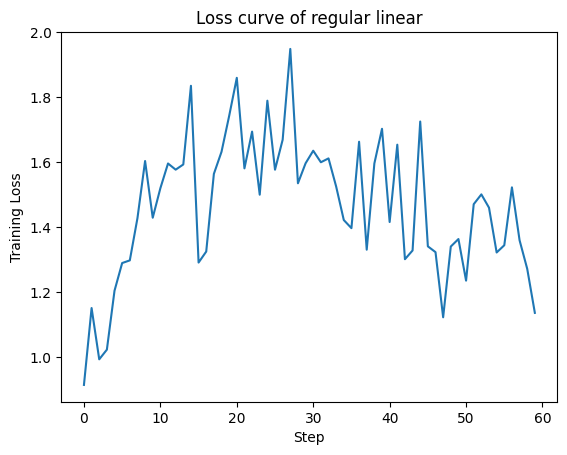

#### Memory Efficient Linear

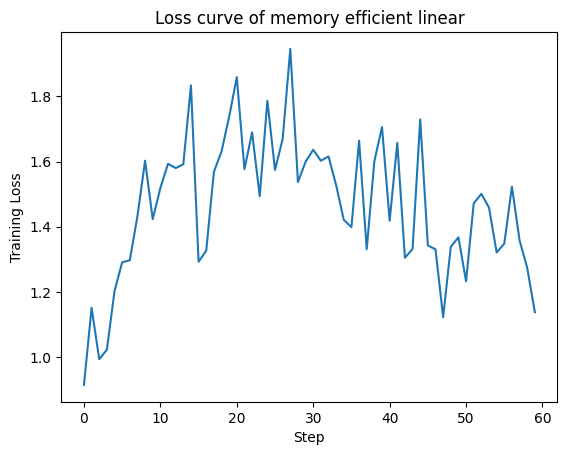

#### Relative Difference

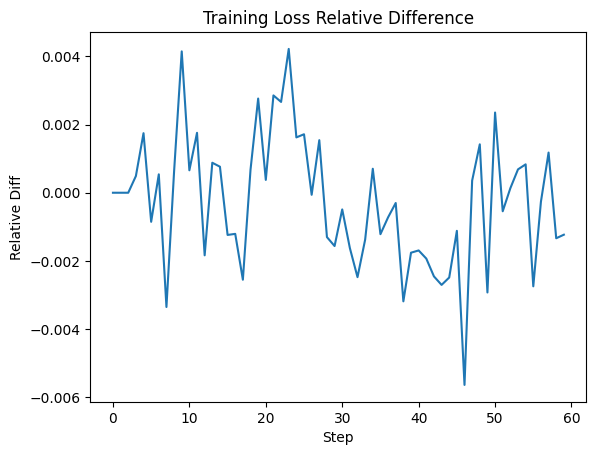

### Test 3: GRPO

**Requirement 1** - `GRPO_memory_efficient_linear_works`

Link to notebook: https://colab.research.google.com/drive/1MmN1DAj3VXxd_EjwSE7cQsqL-93lHbzi